# Assignment 2
### Understanding Uncertainty
### Due 9/12

1. 'State Bottle Retail' is the price at which the bottle is sold, while 'State Bottle Cost' is the price the state pays for a bottle.
- How do you define the most profitable item? Why? Explain your thinking.
- Use `.groupby` calculations to determine the most profitable liquors sold in Iowa.
- Make a plot of the top liquors.

The most profitable item is the greatest of the (retail price - cost of goods sold) * units sold.

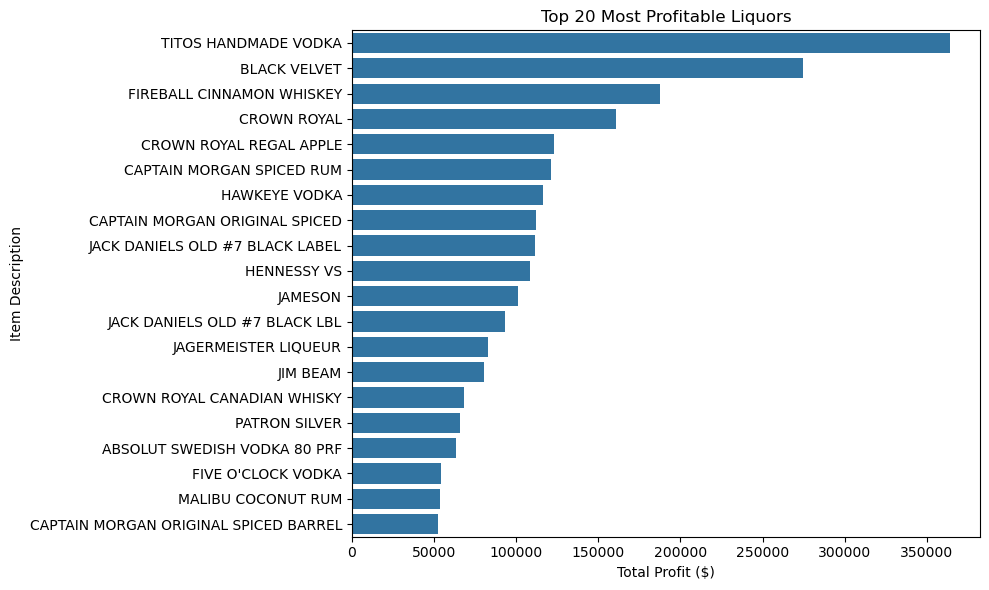

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

idf = pd.read_csv('/home/john/ds5030/understanding_uncertainty/data/iowa.csv') # Iowa Liquor Sales Data

# Calculate profit per item
profit_by_item = (idf.loc[:, ['Item Description', 'Bottles Sold', 'State Bottle Retail', 'State Bottle Cost']]
                 .assign(profit_per_bottle = lambda x: x['State Bottle Retail'] - x['State Bottle Cost'])
                 .assign(total_profit = lambda x: x['profit_per_bottle'] * x['Bottles Sold'])
                 .groupby('Item Description')
                 .agg({
                     'total_profit': 'sum',
                     'Bottles Sold': 'sum'
                 })
                 .sort_values('total_profit', ascending=False))

# Get top 20 most profitable items
top_profit = profit_by_item[:20]

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=top_profit.reset_index(), 
            y='Item Description',
            x='total_profit',
            orient='h')
plt.title('Top 20 Most Profitable Liquors')
plt.xlabel('Total Profit ($)')
plt.tight_layout()

2. This question is to further explore broadcasting in NumPy.

- In the first code chunk below, there are two vectors, $x$ and $y$. What happens when you try to subtract them?
- Instead, try `x.reshape(-1,1)-y.reshape(1,-1)`. What do you get?
- Try `x.reshape(1,-1)-y.reshape(-1,1)`. Compare the results to your previous answer.
- Write two double for-loops to replicate the results of the previous two answers. 
- Clearly explain how `x.reshape(1,-1)` and `x.reshape(-1,1)` change $x$

2.1 Cannot align the arrays to perform subtraction.
2.2 (3,1) and (2,1) arrays that are only compatible in one dimension.
2.3 Still a ValueError and not broadcastable with shapes (1,3) and (1,2).


In [23]:
import numpy as np

x = np.array([1, 3, 5])
y = np.array([2, 5])
result_list = []
for x_val in x:
    for y_val in y:
        result_list.append(x_val - y_val)
        
result = np.array(result_list).reshape(len(x), len(y))
print(result)

[[-1 -4]
 [ 1 -2]
 [ 3  0]]


Can also be written more efficiently as:
result = x.reshape(-1, 1) - y

NumPy broadcasts the vectors into a compatible shape before subtraction.

3. The indicator function $\mathbb{I}\{ x \le z \}$ takes the value 0 if $x>z$ and 1 if $x \le z$ is true, or
$$
\mathbb{I}\{x \le z\} = \begin{cases}
0, &x > z \\
1, &x \le z
\end{cases}
$$

- For $x = 3$, plot the indicator function for any $z$
- Explain how $ 1- \mathbb{I}\{ x \le z \} = \mathbb{I}\{ x > z \}$. Drawing a plot might help, or looking at the definition given above.
- The code below generates a random sample for different numbers of observations, $N = 3, 30, 300, 3000 $. Write a function to compute the ECDF curve for each sample, and plot your results.
- Describe in your own words what happens to the ECDF qualitatively as the sample size $N$ increases

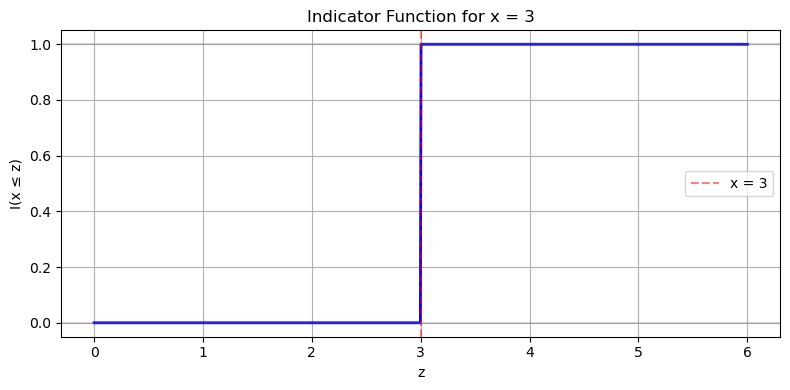

In [24]:
import numpy as np
import matplotlib.pyplot as plt

x = 3
z = np.linspace(0, 6, 1000)

indicator = (x <= z).astype(int)

plt.figure(figsize=(8, 4))
plt.plot(z, indicator, 'b-', linewidth=2)
plt.grid(True)
plt.xlabel('z')
plt.ylabel('I(x ≤ z)')
plt.title(f'Indicator Function for x = {x}')

plt.axvline(x=x, color='r', linestyle='--', alpha=0.5, label='x = 3')

plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.axhline(y=1, color='gray', linestyle='-', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

1−I(x≤z) = I(x>z)

Since the equality holds true in all possible cases, the identity is proven. The indicator function for a statement and the indicator function for its logical complement must sum to 1.

In [4]:
import numpy as np
import seaborn as sns

rng = np.random.default_rng(100)

for N in (3,30,300,3000):
    X = rng.normal(0,1,N)
    # ECDF plot goes here:


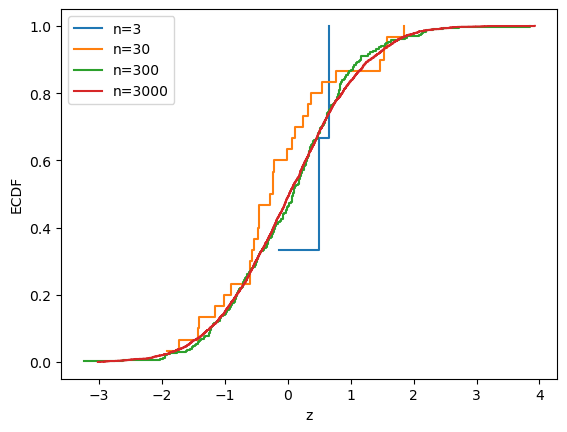

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

np.random.seed(42)
sample_sizes = [3, 30, 300, 3000]

for n in sample_sizes:
    data = np.random.randn(n)
    x, y = ecdf(data)
    plt.step(x, y, where='post', label=f'n={n}')

plt.legend()
plt.xlabel("z")
plt.ylabel("ECDF")
plt.show()

As the sample size increases the ECDF approaches the CDF. As you collect more data your estimate approaches the correct distribution.

4. A **quantile** generalizes the concept of the median so that instead of 50% of the mass below and 50% above, the $q$-quantile is the value for which $q$ proportion of the data are below that value and $(1-q)$ proportion of the data are above that value. This is a concept of **order**.

- Write a function that computes any quantile without using Numpy's `np.quantile`
- Write a function that computes the **Interquartile Range (IQR)** -- the .25 quantile and the .75 quantile, which brackets 50% of the data -- and the **whiskers**: $\pm 1.5 \times \text{IQR}$ from the edges of the IQR
- Write a function that computes a five-number summary and values for a boxplot: the minimum, the .25 quantile, the median, the .75 quantile, and the maximum, and the whiskers
- Anything outside the whiskers is an **outlier**; write a function that returns a Boolean vector indicating if the observations are outliers.
- For a numeric variable of your choice from one of the datasets, apply your functions from above, and compare your answers with `sns.boxplot` and `df.describe`. 

In [26]:
def quantile(data, q):
    data = sorted(data)
    n = len(data)
    pos = (n - 1) * q
    lower, upper = int(pos), int(pos) + 1
    if upper >= n:
        return data[lower]
    return data[lower] + (pos - lower) * (data[upper] - data[lower])


5. The kernel density estimator captures the concentration of the data around various points, and is defined as
$$
\hat{f}_{N,h}(z) = \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k \left( \frac{x_i - z}{h}\right)
$$
where $h$ is the bandwidth and $k()$ is one of the kernel functions from the class materials (Gaussian, Epanechnikov, uniform, triangular).

- Write a function that takes the bandwidth $h$ as given, and computes and plots $\hat{f}_{N,h}(z)$, for the kernels listed in the slides
- Write a function that computes the plug-in bandwidth
- Use your functions to analyze some numeric variables from a dataset of your choice, using a variety of bandwidths
- Compare bandwidths that are greater or less than the plug-in value with the results for the plug-in value. When does the KDE appear to be overfitting? Underfitting?